In [2]:
import os
import glob
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple
from PSSimPy.simulator import ABMSim
from PSSimPy import Bank
from PSSimPy.credit_facilities import SimpleCollateralized
from PSSimPy.utils import add_minutes_to_time

# Original Intrady Liquidity Game

## Set Up Strategic Behavior

In [3]:
# state: s = (t, b, β, ω, E)
MDPState = namedtuple("MDPState", [
    "t", 
    "balance", 
    "borrowed", 
    "obligations", 
    "expected_inbound"
])

In [4]:
class OriMDPSearch:
    """
    MDP formulation for the focal player's decision in an n-player Intraday Liquidity Game.
    
    State: s = (t, b, β, ω, E), where:
      - t: current period,
      - b: focal player's balance,
      - β: focal player's borrowed amount,
      - ω: focal player's outstanding obligations,
      - E: aggregate expected inbound payment from the n-1 opponents, 
           given by E_t = (n-1)p_tz^*.
    
    Here, p_t is the probability that an obligation arises (per opponent) in period t.
    If an obligation arises, opponents pay the focal player if their dominant strategy is to pay,
    which (with tie → pay) implies z^* = 1 when γ ≤ δ, and 0 when γ > δ.
    Under pure rational expectations (i.e., with ζ = 0), agents do not update their expectations.
    
    The focal player has two strategies:
      0 = Delay: incur delay cost δ per unit of obligation; obligations carry forward.
      1 = Pay: if b < ω, borrow the shortfall at cost γ per unit; clear obligations;
           any excess balance repays borrowing.
           
    The focal player also pays a carry cost of γ·β each period.
    
    We solve the MDP via depth-limited dynamic programming, reflecting bounded rationality.
    """
    
    def __init__(self, 
                 n_players=4,
                 n_periods=4, 
                 p_t=0.8,      # probability an obligation arises per opponent in a period
                 delta=0.2, 
                 gamma=0.1,
                 zeta=0.0,     # learning rate, set to 0 for pure RE
                 seed=42):
        """
        n_players   : total players (focal + opponents)
        n_periods   : horizon for the MDP
        p_t         : probability an obligation arises per opponent
        delta       : per-unit delay cost
        gamma       : cost for borrowing and carrying borrowed funds
        zeta        : learning rate for updating expectations (set to 0 for pure RE)
        seed        : random seed for reproducibility
        """
        random.seed(seed)
        self.n_players = n_players
        self.n_periods = n_periods
        self.p_t = p_t
        self.delta = delta
        self.gamma = gamma
        self.zeta = zeta  # with zeta=0, no updating occurs
        # Dominant strategy assumption: if γ ≤ δ then opponents pay, i.e., z^*=1; otherwise, z^*=0.
        self.z_star = 1.0 if self.gamma <= self.delta else 0.0

    def initial_state(self):
        """
        The initial state: the focal player's balance, borrowed, and obligations are zero.
        The initial aggregate expected inbound is:
           E₀ = (n_players - 1) * p_t * z_star.
        """
        E0 = (self.n_players - 1) * self.p_t * self.z_star
        return MDPState(
            t=0,
            balance=0.0,
            borrowed=0.0,
            obligations=0.0,
            expected_inbound=E0
        )

    def carry_cost(self, borrowed):
        """Cost for carrying borrowed funds over one period."""
        return self.gamma * borrowed if borrowed > 0 else 0.0

    def transition_function(self, state, action):
        """
        Given state s = (t, b, β, ω, E) and focal action a ∈ {0,1},
        return a list of (next_state, probability, immediate_cost).
        
        Here, we assume that in each period, every opponent independently generates an obligation 
        with probability p_t, so that on average, (n_players - 1)*p_t obligations arrive.
        For simplicity, we assume that the number of new obligations is exactly (n-1)p_t.
        
        The focal player's balance is increased by the aggregate expected inbound E,
        and then the chosen action is applied:
         - If a = 1 (Pay): if b + E < ω + (n-1)p_t, the focal borrows the shortfall (cost = γ*(shortfall)); 
           obligations clear.
         - If a = 0 (Delay): cost = δ times the total obligations.
        In both cases, a carry cost γβ is added.
        """
        if state.t >= self.n_periods:
            return [(state, 1.0, 0.0)]
        
        # Compute carry cost
        cost_carry = self.carry_cost(state.borrowed)
        # Inbound: focal's balance increases by E
        mid_balance = state.balance + state.expected_inbound
        # New obligations: exactly (n-1)p_t arrive
        new_arrivals = (self.n_players - 1) * self.p_t
        new_oblig = state.obligations + new_arrivals

        if action == 1:  # Pay
            shortfall = max(0.0, new_oblig - mid_balance)
            cost_borrow = self.gamma * shortfall if shortfall > 0 else 0.0

            new_balance = mid_balance
            new_borrowed = state.borrowed
            if shortfall > 0:
                new_balance = 0.0
                new_borrowed += shortfall
                new_oblig_after = 0.0
            else:
                new_balance = mid_balance - new_oblig
                new_oblig_after = 0.0

            if new_balance > 0 and new_borrowed > 0:
                repay = min(new_balance, new_borrowed)
                new_borrowed -= repay
                new_balance -= repay

            immediate_cost = cost_carry + cost_borrow
            next_state = MDPState(
                t=state.t + 1,
                balance=new_balance,
                borrowed=new_borrowed,
                obligations=new_oblig_after,
                expected_inbound=state.expected_inbound  # under pure RE, remains constant
            )
            return [(next_state, 1.0, immediate_cost)]
        else:  # Delay
            cost_delay = self.delta * new_oblig
            immediate_cost = cost_carry + cost_delay
            next_state = MDPState(
                t=state.t + 1,
                balance=mid_balance,
                borrowed=state.borrowed,
                obligations=new_oblig,
                expected_inbound=state.expected_inbound
            )
            return [(next_state, 1.0, immediate_cost)]

    def actions(self, state):
        """Return the focal player's actions: 0 = Delay, 1 = Pay."""
        return [0, 1]

    def state_to_key(self, state):
        """Convert state into a hashable tuple for memoization."""
        return (state.t, round(state.balance,4), round(state.borrowed,4),
                round(state.obligations,4), round(state.expected_inbound,4))

    def depth_limited_value(self, state, depth, memo=None):
        """
        Depth-limited lookahead from state up to 'depth' periods.
        Returns (best_value, best_action) where best_value is the maximum expected reward 
        (i.e., negative total cost) and best_action ∈ {0,1}.
        
        This recursive algorithm uses memoization. The limited depth represents the 
        bounded rationality of the focal player in forming its rational expectation.
        """
        if memo is None:
            memo = {}
        if depth <= 0 or state.t >= self.n_periods:
            return (0.0, None)
        key = (self.state_to_key(state), depth)
        if key in memo:
            return memo[key]
        best_value = float('-inf')
        best_action = None
        for a in self.actions(state):
            transitions = self.transition_function(state, a)
            total_val = 0.0
            for (ns, prob, cost) in transitions:
                immediate_reward = -cost  # cost is a negative reward
                future_val, _ = self.depth_limited_value(ns, depth - 1, memo)
                total_val += prob * (immediate_reward + future_val)
            if total_val > best_value:
                best_value = total_val
                best_action = a
        memo[key] = (best_value, best_action)
        return memo[key]

    def update_current_state(self, current_state, focal_action, partial_observations):
        """
        Update the current state based on the focal player's chosen action and partial observations.
        
        partial_observations is a dictionary containing:
          - "inbound_payments": actual inbound payment received,
          - "arrived_obligations": number of new obligations that actually arrived,
          - "observed_expected": observed aggregate inbound (e.g., from opponents).
        
        Under our pure rational expectations assumption (with ζ = 0), the aggregate expectation
        remains fixed as E_t = (n-1)p_tz^*. However, to allow for potential deviations, we include 
        an update rule:
        
          E' = ζ · (observed_expected) + (1 - ζ) · E.
          
        Setting ζ = 0 recovers the pure RE case.
        
        Returns the updated state s' = (t+1, b', β', ω', E').
        """
        observed_inbound = partial_observations.get("inbound_payments", 0.0)
        new_balance_pre = current_state.balance + observed_inbound
        arrived = partial_observations.get("arrived_obligations", 0)
        new_obligations = current_state.obligations + arrived
        observed_expected = partial_observations.get("observed_expected", current_state.expected_inbound)
        new_expected = self.zeta * observed_expected + (1 - self.zeta) * current_state.expected_inbound

        if focal_action == 1:  # Pay
            shortfall = max(0.0, new_obligations - new_balance_pre)
            new_borrowed = current_state.borrowed + shortfall
            if shortfall > 0:
                new_balance = 0.0
                new_oblig_after = 0.0
            else:
                new_balance = new_balance_pre - new_obligations
                new_oblig_after = 0.0
            if new_balance > 0 and new_borrowed > 0:
                repay = min(new_balance, new_borrowed)
                new_borrowed -= repay
                new_balance -= repay
            next_state = MDPState(
                t=current_state.t + 1,
                balance=new_balance,
                borrowed=new_borrowed,
                obligations=new_oblig_after,
                expected_inbound=new_expected
            )
            return next_state
        else:  # Delay
            next_state = MDPState(
                t=current_state.t + 1,
                balance=new_balance_pre,
                borrowed=current_state.borrowed,
                obligations=new_obligations,
                expected_inbound=new_expected
            )
            return next_state

In [5]:
# Smoke test
n_periods = 10
n_players = 10
p_t = 0.8
mdp = OriMDPSearch(
    n_players=n_players,
    n_periods=n_periods,
    p_t=p_t,
    delta=0.3,
    gamma=0.2,
    seed=1000
)

init_state = mdp.initial_state()
print("Initial state:", init_state)
next_state = init_state

while n_periods > 0:
    best_val, best_act = mdp.depth_limited_value(next_state, depth=n_periods)
    print(f"Best value = {best_val:.2f}, best action = {'DELAY' if best_act==0 else 'PAY'}")

    # actual partial observations
    inbound_payments = sum([1 if random.uniform(0.0, 1.0) <= p_t else 0 for _ in range(n_players - 1)])
    arrived_obligations = sum([1 if random.uniform(0.0, 1.0) <= p_t else 0 for _ in range(n_players - 1)])
    partial_obs = {
        "inbound_payments": inbound_payments,
        "arrived_obligations": arrived_obligations,
        "observed_expected": 0.75 # not important
    }

    # next state
    next_state = mdp.update_current_state(next_state, best_act, partial_obs)
    print(next_state)
    print("Updated state after partial observations and chosen action:", next_state)

    n_periods -= 1

Initial state: MDPState(t=0, balance=0.0, borrowed=0.0, obligations=0.0, expected_inbound=7.2)
Best value = 0.00, best action = PAY
MDPState(t=1, balance=0.0, borrowed=0.0, obligations=0.0, expected_inbound=7.2)
Updated state after partial observations and chosen action: MDPState(t=1, balance=0.0, borrowed=0.0, obligations=0.0, expected_inbound=7.2)
Best value = 0.00, best action = PAY
MDPState(t=2, balance=0.0, borrowed=2.0, obligations=0.0, expected_inbound=7.2)
Updated state after partial observations and chosen action: MDPState(t=2, balance=0.0, borrowed=2.0, obligations=0.0, expected_inbound=7.2)
Best value = -3.20, best action = PAY
MDPState(t=3, balance=1.0, borrowed=0.0, obligations=0.0, expected_inbound=7.2)
Updated state after partial observations and chosen action: MDPState(t=3, balance=1.0, borrowed=0.0, obligations=0.0, expected_inbound=7.2)
Best value = 0.00, best action = PAY
MDPState(t=4, balance=0.0, borrowed=0.0, obligations=0.0, expected_inbound=7.2)
Updated state af

In [6]:
mdp = OriMDPSearch(
    n_players=10,
    n_periods=10,
    p_t=0.8, # to be defined as a global variable
    delta=0.3, # to be defined as a global variable
    gamma=0.2, # to be defined as a global variable
    seed=42
)

# Set up strategic bank agent
class OriStrategicBank(Bank):

    def __init__(self, name, strategy_type='OriStrategic', **kwargs):
        super().__init__(name, strategy_type, **kwargs)
        self.mdp_state = mdp.initial_state() # mdp needs to be redefined before each simulation run
        self.mdp_previous_action = 0
        self.n_periods = 10
    
    # overwrite strategy
    def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
        if len(txns_to_settle) == 0:
            return set()
        else:
            # we assume 1:1 mapping of bank to account so we can just extract any txn and use that account
            txn = txns_to_settle.copy().pop()
            bank_account = txn.sender_account

        if current_time == "08:00":
            pass
        else:
            # calculate actual inbound payments from previous period
            previous_time = add_minutes_to_time(current_time, -15)
            df_processed_txns = pd.read_csv(f'{sim_name}-processed_transactions.csv')
            filtered_df = df_processed_txns[(df_processed_txns['to_account'] == bank_account) & 
                    (df_processed_txns['settlement_time'] == previous_time)]
            inbound_payments = filtered_df['amount'].sum()

            # calculate amount of obligations that arrived in this period
            arrived_obligations = sum([txn.amount for txn in txns_to_settle if txn.arrival_time == current_time])

            partial_obs = {
                "inbound_payments": inbound_payments,
                "arrived_obligations": arrived_obligations,
                "observed_expected": 0.75 # not important
            }

            self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)

        _, best_act = mdp.depth_limited_value(self.mdp_state, depth=self.n_periods)
        self.n_periods -= 1
        self.mdp_previous_action = best_act

        if best_act == 1:
            return txns_to_settle
        else:
            return set()
        

In [7]:
class RandomBank(Bank):
    def __init__(self, name, strategy_type='OriStrategic', **kwargs):
        super().__init__(name, strategy_type, **kwargs)

    # overwrite strategy
    def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
        r = random.randint(0, 1)
        if r == 1:
            return txns_to_settle
        else:
            return set()

## Calculation functions

In [8]:
def calculate_delay_cost(sim_name, account: str, delta: float):
    df_processed_txns = pd.read_csv(f"{sim_name}-processed_transactions.csv")

    # Filter transactions for the given account
    relevant_txns = df_processed_txns[df_processed_txns['from_account'] == account]
    
    # Initialize total delay cost
    total_delay_cost = 0
    
    # Calculate delay cost for each transaction
    for _, row in relevant_txns.iterrows():
        # Extract submission_time and time as datetime objects
        submission_time = pd.to_datetime(row['submission_time'])
        txn_time = pd.to_datetime(row['time'])
        
        # Calculate the delay in minutes (convert Timedelta to minutes)
        delay_minutes = (submission_time - txn_time).total_seconds() / 60
        
        # Calculate the delay cost
        delay_cost = (delay_minutes / 15) * delta
        
        # Accumulate the delay cost
        total_delay_cost += delay_cost
    
    return total_delay_cost

In [9]:
def calculate_borrowing_cost(sim_name, account: str, gamma: float):
    df_credit_facility = pd.read_csv(f'{sim_name}-credit_facility.csv')
    
    # Filter for the given account
    relevant_credit = df_credit_facility[df_credit_facility['account'] == account]

    # Initialize total borrowing cost
    total_borrowing_cost = 0

    # Calculate borrowing cost at each period
    for _, row in relevant_credit.iterrows():
        borrowed_amount = row['total_credit']
        borrowing_cost = borrowed_amount * gamma
        total_borrowing_cost += borrowing_cost
    
    return total_borrowing_cost

## Simulation

In [10]:
# banks = pd.read_csv('data_input/bank_template_with_strategy.csv')
# accounts = pd.read_csv('data_input/account_template_with_collateral.csv')

# strategy_mapping = {'OriStrategic': OriStrategicBank, 'Random': RandomBank}

# sim = ABMSim(name='test_sim', banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, credit_facility=SimpleCollateralized(), open_time='08:00', close_time='10:30', eod_force_settlement=True, txn_arrival_prob=0.8, txn_amount_range=(1,1))
# sim.run()

## Original Game - Strategic vs Not Strategic

#### Functions

In [11]:
def simulate_original_game(p_t: float, delta: float, gamma: float, seed: int, strategic_template: int, focal_account='acc3'):
    """
    Strategic template: 
    - 1 = Strategic vs Random
    - 2 = Normal vs Random
    - 3 = Strategic vs Strategic
    - 4 = Normal vs Normal
    """
    mdp = OriMDPSearch(
        n_players=40,
        n_periods=40,
        p_t=p_t,
        delta=delta,
        gamma=gamma,
        seed=seed
    )

    # redefine strategic bank
    # Set up strategic bank agent
    class OriStrategicBank(Bank):

        def __init__(self, name, strategy_type='OriStrategic', **kwargs):
            super().__init__(name, strategy_type, **kwargs)
            self.mdp_state = mdp.initial_state() # mdp needs to be redefined before each simulation run
            self.mdp_previous_action = 0
            self.n_periods = 40
        
        # overwrite strategy
        def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
            if len(txns_to_settle) == 0:
                return set()
            else:
                # we assume 1:1 mapping of bank to account so we can just extract any txn and use that account
                txn = txns_to_settle.copy().pop()
                bank_account = txn.sender_account

            if current_time == "08:00":
                pass
            else:
                # calculate actual inbound payments from previous period
                previous_time = add_minutes_to_time(current_time, -15)
                df_processed_txns = pd.read_csv(f'{sim_name}-processed_transactions.csv')
                filtered_df = df_processed_txns[(df_processed_txns['to_account'] == bank_account) & 
                        (df_processed_txns['settlement_time'] == previous_time)]
                inbound_payments = filtered_df['amount'].sum()

                # calculate amount of obligations that arrived in this period
                arrived_obligations = sum([txn.amount for txn in txns_to_settle if txn.arrival_time == current_time])

                partial_obs = {
                    "inbound_payments": inbound_payments,
                    "arrived_obligations": arrived_obligations,
                    "observed_expected": 0.75 # not important
                }

                self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)

            _, best_act = mdp.depth_limited_value(self.mdp_state, depth=self.n_periods)
            self.n_periods -= 1
            self.mdp_previous_action = best_act

            if best_act == 1:
                return txns_to_settle
            else:
                return set()
        
    strategy_mapping = {'OriStrategic': OriStrategicBank, 'Random': RandomBank}
            

    # strategic play
    if strategic_template == 1:
        banks = pd.read_csv('data_input/bank_template_with_strategy.csv')
    elif strategic_template == 2:
        banks = pd.read_csv('data_input/bank_template_with_strategy_1.csv')
    elif strategic_template == 3:
        banks = pd.read_csv('data_input/bank_template_with_strategy_2.csv')
    else:
        banks = pd.read_csv('data_input/bank_template.csv')
    accounts = pd.read_csv('data_input/account_template_with_collateral.csv')
    sim_name = 'test_sim'
    sim = ABMSim(name=sim_name, banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, credit_facility=SimpleCollateralized(), open_time='08:00', close_time='18:00', eod_force_settlement=True, txn_arrival_prob=0.8, txn_amount_range=(1,1))
    sim.run()
    
    # extract costs
    delay_costs = {}
    borrowing_costs = {}
    for account in accounts['id'].tolist():
        delay_costs[account] = calculate_delay_cost(sim_name, account, delta)
        borrowing_costs[account] = calculate_borrowing_cost(sim_name, account, gamma)

    # tear down
    # Remove each .csv file
    csv_files = glob.glob("*.csv")
    for file in csv_files:
        os.remove(file)

    return delay_costs[focal_account] + borrowing_costs[focal_account]

In [12]:
def visualize_costs(total_costs_1: list, total_costs_2: list, label_1="Scenario 1", label_2="Scenario 2", title='Comparison of Total Cost Distributions'):
    # Convert to numpy arrays
    costs_1 = np.array(total_costs_1)
    costs_2 = np.array(total_costs_2)

    # Compute summary statistics
    mean_cost_1 = np.mean(costs_1)
    median_cost_1 = np.median(costs_1)
    std_cost_1 = np.std(costs_1)
    
    mean_cost_2 = np.mean(costs_2)
    median_cost_2 = np.median(costs_2)
    std_cost_2 = np.std(costs_2)
    
    print(f"{label_1}:")
    print("Mean total cost:", mean_cost_1)
    print("Median total cost:", median_cost_1)
    print("Standard Deviation:", std_cost_1)
    print("")

    print(f"{label_2}:")
    print("Mean total cost:", mean_cost_2)
    print("Median total cost:", median_cost_2)
    print("Standard Deviation:", std_cost_2)
    print("")

    # Plot histograms
    plt.figure(figsize=(8,6))
    plt.hist(costs_1, bins='auto', density=True, alpha=0.5, color='blue', edgecolor='black', label=label_1)
    plt.hist(costs_2, bins='auto', density=True, alpha=0.5, color='orange', edgecolor='black', label=label_2)

    # Overlay the mean and median as vertical lines
    plt.axvline(mean_cost_1, color='blue', linestyle='dashed', linewidth=2, label=f'{label_1} Mean: {mean_cost_1:.2f}')
    plt.axvline(median_cost_1, color='blue', linestyle='dotted', linewidth=2, label=f'{label_1} Median: {median_cost_1:.2f}')
    
    plt.axvline(mean_cost_2, color='orange', linestyle='dashed', linewidth=2, label=f'{label_2} Mean: {mean_cost_2:.2f}')
    plt.axvline(median_cost_2, color='orange', linestyle='dotted', linewidth=2, label=f'{label_2} Median: {median_cost_2:.2f}')

    plt.title(title)
    plt.xlabel('Total Cost')
    plt.ylabel('Density')
    plt.legend()

    plt.show()


#### Delay Costs > Borrowing Costs

In [13]:
p_t = 0.8
delta = 0.3
gamma = 0.2
n_simulations = 100

In [14]:
total_costs_strategic = []
total_costs_non_strategic = []

for sim_seed in range(1000, 1000 + n_simulations):
    random.seed(sim_seed)
    np.random.seed(sim_seed)
    
    total_cost_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, 1)
    total_costs_strategic.append(total_cost_strategic)

    total_cost_non_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, 2)
    total_costs_non_strategic.append(total_cost_non_strategic)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3781520/1063082311.py:1: SyntaxWarning: invalid escape sequence '\d'
  visualize_costs(total_costs_strategic, total_costs_non_strategic, 'Strategic', 'Non-Strategic', title='Comparison of Total Cost Distributions When $\delta > \gamma$ and Other Banks Are Randomly Strategic')


Strategic:
Mean total cost: 48.81400000000001
Median total cost: 48.29999999999997
Standard Deviation: 16.922582663411635

Non-Strategic:
Mean total cost: 48.81400000000001
Median total cost: 48.29999999999997
Standard Deviation: 16.922582663411635



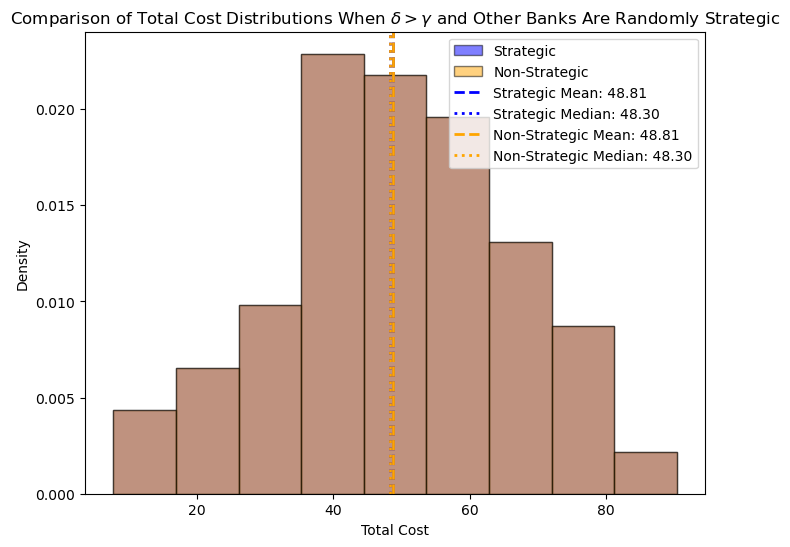

In [15]:
visualize_costs(total_costs_strategic, total_costs_non_strategic, 'Strategic', 'Non-Strategic', title='Comparison of Total Cost Distributions When $\delta > \gamma$ and Other Banks Are Randomly Strategic')

#### Delay Costs < Borrowing Costs

When $\delta < \gamma$ but $\delta > (1 - p_t)\gamma$, the theory states that it would be the dominant strategy for players to delay but they would actually be better off not delaying.

<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_3781520/4010087111.py:18: SyntaxWarning: invalid escape sequence '\g'
  visualize_costs(total_costs_strategic, total_costs_non_strategic, 'Strategic', 'Non-Strategic', title='Comparison of Total Cost Distributions When $(1-p_t)\gamma < \delta < \gamma$ and Other Banks Are Randomly Strategic')


Strategic:
Mean total cost: 262.126
Median total cost: 266.4000000000001
Standard Deviation: 17.445266521323195

Non-Strategic:
Mean total cost: 73.22099999999999
Median total cost: 72.45000000000002
Standard Deviation: 25.383873995117447



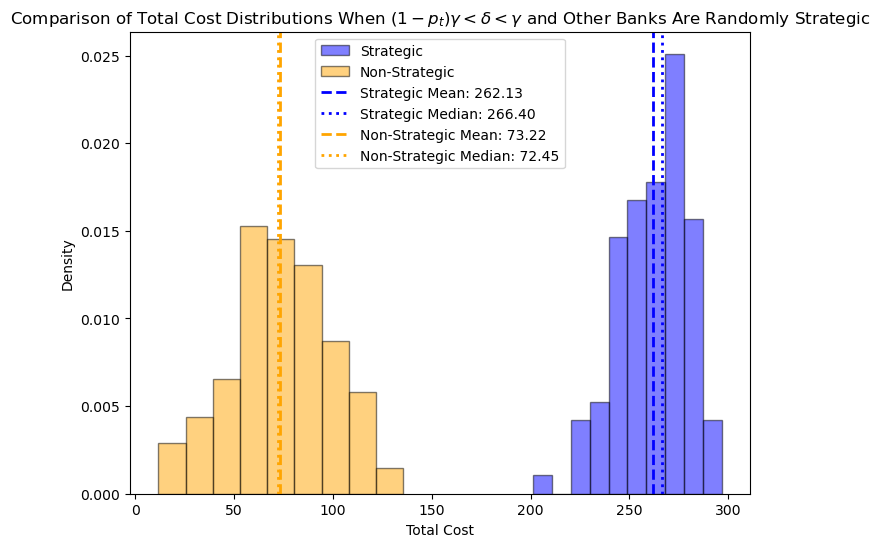

In [16]:
# vs random
p_t = 0.8
delta = 0.2
gamma = 0.3
n_simulations = 100

total_costs_strategic = []
total_costs_non_strategic = []

for sim_seed in range(1000, 1000 + n_simulations):
    random.seed(sim_seed)
    total_cost_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, 1)
    total_costs_strategic.append(total_cost_strategic)

    total_cost_non_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, 2)
    total_costs_non_strategic.append(total_cost_non_strategic)

visualize_costs(total_costs_strategic, total_costs_non_strategic, 'Strategic', 'Non-Strategic', title='Comparison of Total Cost Distributions When $(1-p_t)\gamma < \delta < \gamma$ and Other Banks Are Randomly Strategic')

<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_3781520/2800764305.py:18: SyntaxWarning: invalid escape sequence '\g'
  visualize_costs(total_costs_strategic, total_costs_non_strategic, 'Strategic', 'Non-Strategic', title='Comparison of Total Cost Distributions When $(1-p_t)\gamma < \delta < \gamma$ and All Banks Are Deterministically Strategic or Not Strategic')


Strategic:
Mean total cost: 261.28
Median total cost: 263.5
Standard Deviation: 18.00722077390067

Non-Strategic:
Mean total cost: 43.36199999999999
Median total cost: 42.45
Standard Deviation: 19.677641017154475



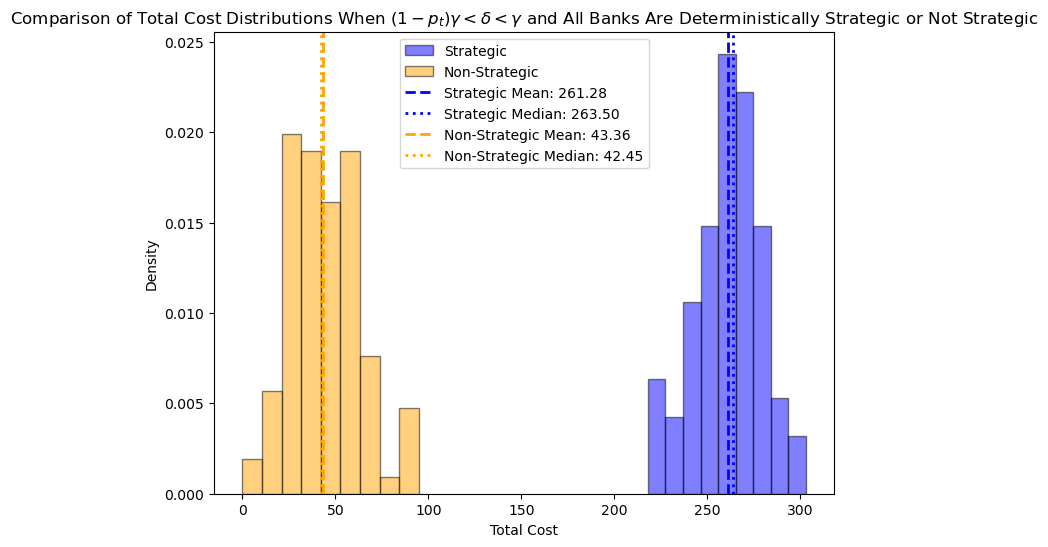

In [17]:
# vs banks that are either all strategic or non-strategic
p_t = 0.8
delta = 0.2
gamma = 0.3
n_simulations = 100

total_costs_strategic = []
total_costs_non_strategic = []

for sim_seed in range(1000, 1000 + n_simulations):
    random.seed(sim_seed)
    total_cost_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, 3)
    total_costs_strategic.append(total_cost_strategic)

    total_cost_non_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, 4)
    total_costs_non_strategic.append(total_cost_non_strategic)

visualize_costs(total_costs_strategic, total_costs_non_strategic, 'Strategic', 'Non-Strategic', title='Comparison of Total Cost Distributions When $(1-p_t)\gamma < \delta < \gamma$ and All Banks Are Deterministically Strategic or Not Strategic')

When $\delta < (1-p_t)\gamma$, we should see that they would always be better off delaying.

In [18]:
p_t = 0.5
delta = 0.1
gamma = 0.9
n_simulations = 100

In [19]:
total_costs_strategic = []
total_costs_non_strategic = []

for sim_seed in range(1000, 100 + n_simulations):
    random.seed(sim_seed)
    total_cost_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, 1)
    total_costs_strategic.append(total_cost_strategic)

    total_cost_non_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, 2)
    total_costs_non_strategic.append(total_cost_non_strategic)

Strategic:
Mean total cost: nan
Median total cost: nan
Standard Deviation: nan

Non-Strategic:
Mean total cost: nan
Median total cost: nan
Standard Deviation: nan



<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3781520/877075345.py:1: SyntaxWarning: invalid escape sequence '\d'
  visualize_costs(total_costs_strategic, total_costs_non_strategic, 'Strategic', 'Non-Strategic', title='Comparison of Total Cost Distributions When $\delta < (1-p_t)\gamma$ and Other Banks Are Randomly Strategic')
/home/sdkenneth/miniconda3/envs/intradayliquiditygame/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdkenneth/miniconda3/envs/intradayliquiditygame/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/sdkenneth/miniconda3/envs/intradayliquiditygame/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, d

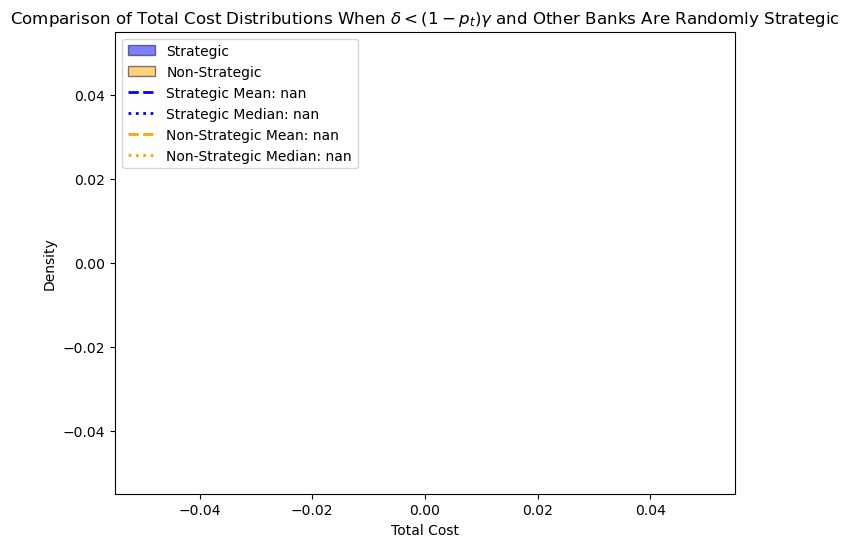

In [20]:
visualize_costs(total_costs_strategic, total_costs_non_strategic, 'Strategic', 'Non-Strategic', title='Comparison of Total Cost Distributions When $\delta < (1-p_t)\gamma$ and Other Banks Are Randomly Strategic')

# Blockchain Mechanism Game

The mechanism consists of two parts
1. The ICF accepting tokenized incoming transactions as collateral
2. Additional delay cost imposed by designer

## Set up strategic behavior

In [21]:
# Extended state with separate borrowed balances and tracking of claims.
MDPStateExt = namedtuple("MDPStateExt", [
    "t",              # current period
    "balance",        # cash balance
    "borrowed_trad",  # amount borrowed traditionally (cost γ)
    "borrowed_claim", # amount borrowed via pledged incoming (cost φ)
    "borrowed_unsecured", # amount borrowed via unsecured loan (cost χ)
    "obligations",    # outstanding obligations the focal player owes
    "claims",         # outstanding claims (money owed to the focal player)
    "expected_inbound"  # aggregated expected inbound payment from others
])

In [86]:
class MechMDPSearch:
    """
    MDP formulation for the focal player's decision in an n-player Intraday Liquidity Game with a mechanism.
    
    Extended State: 
      s = (t, b, β_trad, β_claim, β_unsecured, ω, C, E),
    where:
      - t: current period,
      - b: focal player's cash balance,
      - β_trad: funds borrowed via traditional channel (cost γ),
      - β_claim: funds borrowed via pledged transactions (cost φ),
      - β_unsecured: funds borrowed via unsecured loans (cost χ),
      - ω: outstanding obligations (already learned for the current period),
      - C: outstanding claims (already learned),
      - E: aggregate expected inbound payment from the n-1 opponents, given by E = (n-1)*p_t (with z* = 1 under pure RE).
    
    The focal player has two strategies:
      0 = Delay: incur delay cost δ per unit (plus additional cost δ′) on outstanding obligations, which then accumulate.
      1 = Pay: attempt to settle all obligations using its current balance. If insufficient,
           borrow the shortfall using the cheaper channel (traditional if γ < φ, or pledged otherwise; if collateral is unavailable, use unsecured).
           After payment, the expected inbound is added to the balance, and any excess cash is used to repay outstanding borrowing.
           
    A carry cost is incurred on borrowed funds (γ for traditional, φ for pledged) each period.
    
    We solve the MDP via depth-limited dynamic programming.
    """
    
    def __init__(self, 
                 n_players=40,
                 n_periods=40, 
                 has_collateral=True,
                 p_t=0.8,       # probability an obligation arises per opponent per period
                 delta=0.2,     # per-unit delay cost
                 delta_prime=0.15,  # additional delay cost imposed by the mechanism
                 gamma=0.1,     # traditional borrowing cost
                 phi=0.05,      # pledged-collateral borrowing cost
                 chi=0.3,       # unsecured borrowing cost
                 zeta=0.0,      # learning rate (set to 0 for pure RE)
                 seed=42):
        random.seed(seed)
        self.n_players = n_players
        self.n_periods = n_periods
        self.p_t = p_t
        self.delta = delta
        self.delta_prime = delta_prime
        self.gamma = gamma
        self.phi = phi
        self.chi = chi
        self.zeta = zeta  # under pure RE, no updating
        self.has_collateral = has_collateral
        # Under our mechanism, we set z* = 1.
        self.z_star = 1.0

    def initial_state(self):
        """
        The initial state: balance, borrowed amounts, obligations, and claims are zero.
        Expected inbound: E₀ = (n_players - 1) * p_t * z_star.
        """
        E0 = (self.n_players - 1) * self.p_t * self.z_star
        return MDPStateExt(
            t=0,
            balance=0.0,
            borrowed_trad=0.0,
            borrowed_claim=0.0,
            borrowed_unsecured=0.0,
            obligations=0.0,
            claims=0.0,
            expected_inbound=E0
        )

    def transition_function(self, state, action):
        """
        Transition function for one period.
        
        We assume that at the decision point, the state has already been updated with:
          - New obligations arrived (ω reflects the current period's obligations).
          - Any updates from the previous period (repayments, claim collections) have been applied.
        
        Then the focal player makes a decision using its current balance b, obligations ω, and claims C.
        
        If action == PAY:
          - Compute shortfall = max(0, ω - b).
          - Borrow the shortfall using the cheaper channel:
               if has_collateral: use pledged if φ < γ and φ < χ; else traditional;
               if no collateral: use unsecured.
          - Payment reduces the balance by ω (or sets balance to 0 if borrowing occurred).
        Then, the expected inbound E is received and added to the balance.
        Borrowing costs and carry costs are computed.
        Any excess cash is used to repay outstanding borrowing.
        Finally, if PAY, obligations are cleared; if DELAY, obligations remain.
        """
        if state.t >= self.n_periods:
            return [(state, 1.0, 0.0)]
        
        # Use the obligations already in state (they have been learned).
        total_oblig = state.obligations
        current_balance = state.balance  # current cash available (before receiving E)
        
        if action == 1:  # PAY
            shortfall = max(0.0, total_oblig - current_balance)
            # Borrowing decision:
            if shortfall > 0:
                if self.has_collateral:
                    if self.phi < self.gamma and self.phi < self.chi:
                        add_borrowed_claim = shortfall
                        add_borrowed_trad = 0.0
                        add_borrowed_unsecured = 0.0
                    elif self.gamma < self.chi:
                        add_borrowed_trad = shortfall
                        add_borrowed_claim = 0.0
                        add_borrowed_unsecured = 0.0
                    else:
                        add_borrowed_unsecured = shortfall
                        add_borrowed_trad = 0.0
                        add_borrowed_claim = 0.0
                else:
                    add_borrowed_unsecured = shortfall
                    add_borrowed_trad = 0.0
                    add_borrowed_claim = 0.0
            else:
                add_borrowed_trad = 0.0
                add_borrowed_claim = 0.0
                add_borrowed_unsecured = 0.0
            
            new_borrowed_trad = state.borrowed_trad + add_borrowed_trad
            new_borrowed_claim = state.borrowed_claim + add_borrowed_claim
            new_borrowed_unsecured = state.borrowed_unsecured + add_borrowed_unsecured
            
            # Execute payment: if shortfall > 0, balance goes to 0; otherwise, reduce by total_oblig.
            if shortfall > 0:
                balance_after_payment = 0.0
            else:
                balance_after_payment = current_balance - total_oblig
            
            # Now, the expected inbound arrives.
            updated_balance = balance_after_payment + state.expected_inbound
            
            # Immediate cost: borrowing cost (for shortfall) plus carry cost.
            cost_borrow = (new_borrowed_trad * self.gamma + new_borrowed_claim * self.phi + new_borrowed_unsecured * self.chi) if shortfall > 0 else 0.0
            immediate_cost = cost_borrow
            
            # Repayment: use any excess cash to repay borrowed funds.
            total_borrowed = new_borrowed_trad + new_borrowed_claim + new_borrowed_unsecured
            if updated_balance > 0 and total_borrowed > 0:
                repay_amount = min(updated_balance, total_borrowed)
                if self.gamma >= self.phi:
                    repay_trad = min(repay_amount, new_borrowed_trad)
                    new_borrowed_trad -= repay_trad
                    repay_amount -= repay_trad
                    repay_claim = min(repay_amount, new_borrowed_claim)
                    new_borrowed_claim -= repay_claim
                    repay_unsecured = min(repay_amount, new_borrowed_unsecured)
                    new_borrowed_unsecured -= repay_unsecured
                    updated_balance -= (repay_trad + repay_claim + repay_unsecured)
                else:
                    repay_claim = min(repay_amount, new_borrowed_claim)
                    new_borrowed_claim -= repay_claim
                    repay_amount -= repay_claim
                    repay_trad = min(repay_amount, new_borrowed_trad)
                    new_borrowed_trad -= repay_trad
                    repay_unsecured = min(repay_amount, new_borrowed_unsecured)
                    new_borrowed_unsecured -= repay_unsecured
                    updated_balance -= (repay_claim + repay_trad + repay_unsecured)
            
            # If PAY, obligations are cleared.
            new_oblig_after = 0.0
            
            next_state = MDPStateExt(
                t = state.t + 1,
                balance = updated_balance,
                borrowed_trad = new_borrowed_trad,
                borrowed_claim = new_borrowed_claim,
                borrowed_unsecured = new_borrowed_unsecured,
                obligations = new_oblig_after,
                claims = state.claims,  # unchanged here
                expected_inbound = state.expected_inbound
            )
            return [(next_state, 1.0, immediate_cost)]
        
        else:  # DELAY
            # Under DELAY, obligations remain (accumulate).
            new_oblig_after = total_oblig
            updated_balance = current_balance + state.expected_inbound
            # Delay cost is δ + δ′ per unit.
            cost_delay = (self.delta + self.delta_prime) * new_oblig_after
            immediate_cost = cost_delay
            
            next_state = MDPStateExt(
                t = state.t + 1,
                balance = updated_balance,
                borrowed_trad = state.borrowed_trad,
                borrowed_claim = state.borrowed_claim,
                borrowed_unsecured = state.borrowed_unsecured,
                obligations = new_oblig_after,
                claims = state.claims,
                expected_inbound = state.expected_inbound
            )
            return [(next_state, 1.0, immediate_cost)]
    
    def actions(self, state):
        """Return the focal player's actions: 0 = Delay, 1 = Pay."""
        return [0, 1]
    
    def state_to_key(self, state):
        """Convert state into a hashable tuple for memoization."""
        return (state.t, round(state.balance, 4), round(state.borrowed_trad, 4),
                round(state.borrowed_claim, 4), round(state.borrowed_unsecured, 4),
                round(state.obligations, 4), round(state.claims, 4), round(state.expected_inbound, 4))
    
    def depth_limited_value(self, state, depth, memo=None):
        """
        Depth-limited lookahead from state up to 'depth' periods.
        Returns (best_value, best_action) where best_value is the maximum expected reward (i.e., negative total cost)
        and best_action ∈ {0,1}.
        """
        if memo is None:
            memo = {}
        if depth <= 0 or state.t >= self.n_periods:
            return (0.0, None)
        key = (self.state_to_key(state), depth)
        if key in memo:
            return memo[key]
        best_value = float('-inf')
        best_action = None
        for a in self.actions(state):
            transitions = self.transition_function(state, a)
            total_val = 0.0
            for (ns, prob, cost) in transitions:
                immediate_reward = -cost  # cost is negative reward
                future_val, _ = self.depth_limited_value(ns, depth - 1, memo)
                total_val += prob * (immediate_reward + future_val)
            if total_val > best_value:
                best_value = total_val
                best_action = a
        memo[key] = (best_value, best_action)
        return memo[key]
    
    def update_current_state(self, current_state, focal_action, partial_observations):
        """
        Update the current state based on the focal player's chosen action and partial observations.
        
        partial_observations is a dictionary containing:
          - "inbound_payments": actual inbound payment received,
          - "arrived_obligations": number of new obligations that arrived,
          - "observed_claims": amount of claims received,
          - "observed_expected": observed aggregate inbound (not used when ζ = 0).
        
        Under pure RE (ζ = 0), expected_inbound remains constant.
        
        If the previous action was PAY, obligations are reset to the newly arrived obligations.
        In addition, if the action was PAY, update borrowed amounts by checking for shortfall and repayment.
        """
        observed_inbound = partial_observations.get("inbound_payments", 0.0)
        observed_claims = partial_observations.get("observed_claims", 0.0)
        new_balance_pre = current_state.balance + observed_inbound
        # Update claim balance: claims accumulate, but if inbound payments cover some claims, subtract.
        new_claims_pre = current_state.claims + observed_claims - observed_inbound
        
        new_borrowed_trad = current_state.borrowed_trad
        new_borrowed_claim = current_state.borrowed_claim
        new_borrowed_unsecured = current_state.borrowed_unsecured
        
        arrived = partial_observations.get("arrived_obligations", 0)
        new_obligations = current_state.obligations + arrived
        observed_expected = partial_observations.get("observed_expected", current_state.expected_inbound)
        new_expected = self.zeta * observed_expected + (1 - self.zeta) * current_state.expected_inbound
        
        # Repayment logic: use available cash to repay borrowed amounts.
        repay_from_cash = new_balance_pre
        repay_b_claim = min(new_borrowed_claim, repay_from_cash)
        new_borrowed_claim -= repay_b_claim
        repay_from_cash -= repay_b_claim
        repay_b_trad = min(new_borrowed_trad, repay_from_cash)
        new_borrowed_trad -= repay_b_trad
        repay_from_cash -= repay_b_trad
        repay_b_unsecured = min(new_borrowed_unsecured, repay_from_cash)
        new_borrowed_unsecured -= repay_b_unsecured
        repay_from_cash -= repay_b_unsecured
        new_balance_pre = new_balance_pre - (repay_b_claim + repay_b_trad + repay_b_unsecured)
        
        if focal_action == 1:  # PAY
            shortfall = max(0.0, new_obligations - new_balance_pre)
            if shortfall > 0:
                remaining_shortfall = shortfall
                add_borrowed_claim = 0.0
                add_borrowed_trad = 0.0
                add_borrowed_unsecured = 0.0
                if (self.phi < self.gamma or not self.has_collateral) and self.phi < self.chi:
                    avail_claim = max(0.0, new_claims_pre - current_state.borrowed_claim)
                    add_borrowed_claim = avail_claim
                    remaining_shortfall -= add_borrowed_claim
                if self.has_collateral and self.gamma < self.chi:
                    add_borrowed_trad = remaining_shortfall
                else:
                    add_borrowed_unsecured = remaining_shortfall
                
                new_borrowed_claim += add_borrowed_claim
                new_borrowed_trad += add_borrowed_trad
                new_borrowed_unsecured += add_borrowed_unsecured
                
                new_balance = 0.0
                new_oblig_after = 0.0
            else:
                new_balance = new_balance_pre - new_obligations
                new_oblig_after = 0.0
            
            next_state = MDPStateExt(
                t = current_state.t + 1,
                balance = new_balance,
                borrowed_trad = new_borrowed_trad,
                borrowed_claim = new_borrowed_claim,
                borrowed_unsecured = new_borrowed_unsecured,
                obligations = new_oblig_after,
                claims = 0.0,
                expected_inbound = new_expected
            )
            return next_state
        
        else:  # DELAY
            next_state = MDPStateExt(
                t = current_state.t + 1,
                balance = new_balance_pre,
                borrowed_trad = new_borrowed_trad,
                borrowed_claim = new_borrowed_claim,
                borrowed_unsecured = new_borrowed_unsecured,
                obligations = new_obligations,
                claims = new_claims_pre,
                expected_inbound = new_expected
            )
            return next_state

In [95]:
# DEBUG
mdp_solver = MechMDPSearch(n_players=3, n_periods=2, p_t=1, delta=0.3, delta_prime=0.25, gamma=0.6, phi=0.5, chi=0.75, seed=1000)
init_state = mdp_solver.initial_state()

partial_obs = {
    "inbound_payments": 0,
    "arrived_obligations": 2,
    "observed_claims": 2,  # Specify the new claims observed this period.
    "observed_expected": 0.75  # if applicable
}
current_state = mdp_solver.update_current_state(init_state, 0, partial_obs)

best_val, best_act = mdp_solver.depth_limited_value(current_state, depth=10)
print(f"Best value = {best_val:.2f}, best action = {'DELAY' if best_act==0 else 'PAY'}")
# partial_obs = {
#         "inbound_payments": 0,
#         "arrived_obligations": 1,
#         "observed_claims": 1,  # adjust if needed
#         "observed_expected": 0.75  # not used when ζ = 0
#     }
# current_state = mdp_solver.update_current_state(init_state, 1, partial_obs)
# print("Updated state after observations:", current_state)

# best_val, best_act = mdp_solver.depth_limited_value(current_state, depth=9)
# print(f"Best value = {best_val:.2f}, best action = {'DELAY' if best_act==0 else 'PAY'}")
# partial_obs = {
#         "inbound_payments": 1,
#         "arrived_obligations": 1,
#         "observed_claims": 1,  # adjust if needed
#         "observed_expected": 0.75  # not used when ζ = 0
#     }
# current_state = mdp_solver.update_current_state(current_state, 1, partial_obs)
# print("Updated state after observations:", current_state)

Best value = -1.00, best action = PAY


In [96]:
mdp_solver = MechMDPSearch(n_players=10, n_periods=10, p_t=1, delta=0.1, delta_prime=0.9, gamma=0.15, phi=0.25, chi=0.35, seed=1000)
init_state = mdp_solver.initial_state()
print("Initial state:", init_state)

current_state = init_state
remaining_periods = mdp_solver.n_periods
while remaining_periods > 0:
    best_val, best_act = mdp_solver.depth_limited_value(current_state, depth=remaining_periods)
    print(f"Best value = {best_val:.2f}, best action = {'DELAY' if best_act==0 else 'PAY'}")
    
    # Generate partial observations (simulate random arrivals)
    if remaining_periods == 10:
        inbound_payments = 0
    else:
        inbound_payments = observed_claims
    observed_claims = sum([1 if random.uniform(0.0, 1.0) <= mdp_solver.p_t else 0 for _ in range(mdp_solver.n_players - 1)])
    arrived_obligations = sum([1 if random.uniform(0.0, 1.0) <= mdp_solver.p_t else 0 for _ in range(mdp_solver.n_players - 1)])
    partial_obs = {
        "inbound_payments": inbound_payments,
        "arrived_obligations": arrived_obligations,
        "observed_claims": observed_claims,  # adjust if needed
        "observed_expected": 0.75  # not used when ζ = 0
    }
    
    current_state = mdp_solver.update_current_state(current_state, best_act, partial_obs)
    print("Updated state after observations:", current_state)
    remaining_periods -= 1

Initial state: MDPStateExt(t=0, balance=0.0, borrowed_trad=0.0, borrowed_claim=0.0, borrowed_unsecured=0.0, obligations=0.0, claims=0.0, expected_inbound=9.0)
Best value = 0.00, best action = DELAY
Updated state after observations: MDPStateExt(t=1, balance=0.0, borrowed_trad=0.0, borrowed_claim=0.0, borrowed_unsecured=0.0, obligations=9.0, claims=9.0, expected_inbound=9.0)
Best value = -1.35, best action = PAY
Updated state after observations: MDPStateExt(t=2, balance=0.0, borrowed_trad=9.0, borrowed_claim=0.0, borrowed_unsecured=0.0, obligations=0.0, claims=0.0, expected_inbound=9.0)
Best value = 0.00, best action = DELAY
Updated state after observations: MDPStateExt(t=3, balance=0.0, borrowed_trad=0.0, borrowed_claim=0.0, borrowed_unsecured=0.0, obligations=9.0, claims=0.0, expected_inbound=9.0)
Best value = -1.35, best action = PAY
Updated state after observations: MDPStateExt(t=4, balance=0.0, borrowed_trad=9.0, borrowed_claim=0.0, borrowed_unsecured=0.0, obligations=0.0, claims=0.